In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
# IPOPT for non linear solver with constraints and bounds
import ipopt

Text(0.5, 1.0, 'Power Law memory kernel over time')

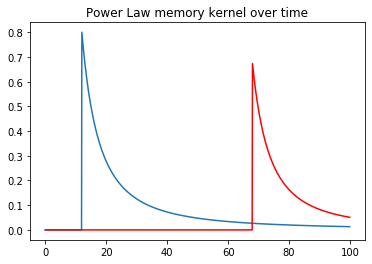

In [3]:
def kernelFct(event, t, K = 0.024, beta = 0.5, mmin = 1, c = 0.001, theta = 0.2):
    mi = event[0]
    ti = event[1] # Origine temporelle
    val_i = np.zeros(len(t))
    #  Le noyau n'est pas défini aux temps < ti et à une magnitude < mmin
    if mi > mmin:
        indices_definis = np.where(t>=ti)[0]
        if len(indices_definis)>0:
            # Virality * Influence of the user * Decaying (relaxation kernel)
            val_i[indices_definis] = K * (mi / mmin)**beta / (t[indices_definis] - ti + c)**(1+theta)
    return(val_i)

# EXEMPLE
event1, event2 = [1000, 12], [750, 68]
t = np.arange(0, 100, 0.1)
K, beta, mmin, c, theta = 0.8, 0.6, 1, 10, 0.8
values_PL1, values_PL2 = kernelFct(event1, t, K, beta, mmin, c, theta), kernelFct(event2, t, K, beta, mmin, c, theta)
plt.plot(t, values_PL1)
plt.plot(t, values_PL2, color='r')
plt.title("Power Law memory kernel over time")

     magnitude    time
0        40989       0
1         1445      21
2          563      31
3          329      33
4          555      49
..         ...     ...
214        146   16453
215        174   17021
216        391   18087
217        188   29186
218         16  241072

[219 rows x 2 columns]


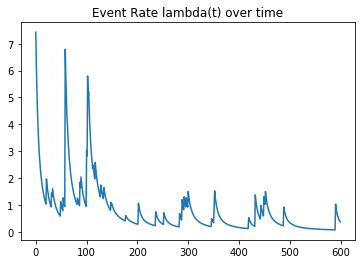

In [5]:
def Lambda(history, t, K = 0.024, beta = 0.5, mmin = 1, c = 0.001, theta = 0.2):
    subset = history[history.time < max(t)]
    Lambda = np.zeros(len(t))
    if not subset.empty:
        kernels = [kernelFct(row.to_numpy(), t, K, beta, mmin, c, theta) for i, row in subset.iterrows()]
        # Somme élément par élément des kernels pour obtenir les coordonnées de Lambda(t)
        kernels_df = pd.DataFrame(data = kernels)
        Lambda = kernels_df.sum(axis=0).to_numpy()
    return(Lambda)

# EXEMPLE
real_cascade = pd.read_csv('example_book.csv')
t = np.arange(0, 600) # Etat du taux d'arrivée d'événements après 600 millisecondes
K, beta, mmin, c, theta = 0.8, 0.6, 1, 10, 0.8
u = Lambda(real_cascade, t, K, beta, mmin, c, theta) # 43 x 600
plt.plot(t, u)
plt.title("Event Rate lambda(t) over time")

print(real_cascade)

In [5]:
def integrateLambda(lower, upper, history, K = 0.024, beta = 0.5, mmin = 1, c = 0.001, theta = 0.2):
    history["apply"] = (history["magnitude"] / mmin)**beta * (1/(theta * c**theta) - 1/(theta * (upper + c - history["time"])**theta))
    result = history["apply"].sum()
    history.drop(columns=["apply"], inplace=True)
    return(result)

# EXEMPLE
real_cascade = pd.read_csv('example_book.csv')
bigT = 10000 # Etat du taux d'arrivée d'événements après 600 millisecondes
K, beta, mmin, c, theta = 0.8, 0.6, 1, 10, 0.8
v = integrateLambda(0, bigT, real_cascade, K, beta, mmin, c, theta)
print("Intégrale de Lambda(t) sur [0, bigT] = ", v)

Intégrale de Lambda(t) sur [0, bigT] =  3663.3882210650177


In [6]:
def neg_log_likelihood(history, K = 0.024, beta = 0.5, mmin = 1, c = 0.001, theta = 0.2):
    bigT = history["time"].max()        
    Lambda_i = [Lambda(history, np.array([tti]), K, beta, mmin, c, theta) for tti in history.loc[1:, "time"]] # On ne compte pas la contribution de l'événement à t=0
    return(integrateLambda(0, bigT, history, K, beta, mmin, c, theta) - sum(np.log(Lambda_i)))

# EXEMPLE
print(neg_log_likelihood(real_cascade, K, beta, mmin, c, theta))

[4043.35842703]


In [ ]:
def closedGradient():
    return 

def contraint():
    return 0

def jacobian():
    return 0

def createStartPoints():
    return 0

# Resolution non linéaire de la minimisation de la log-vraissemblance négative
def fitParameters(x0, history):
    function = neg_log_likelihood()
    jac = # Jacobienne
    hess = # Hessienne
    bounds = [[0,1],[0,1.016],[0, math.inf],[0, math.inf]] # lb & ub
    constraints = ()
    opts = # Options
    nlp = ipopt.minimize_ipopt(fun, x0, method=None, jac=None, hess=None, hessp=None,
                   bounds=None, constraints=(), tol=None, callback=None, options=None)
    return 0

In [ ]:
def getBranchingFactor(K = 0.024, alpha = 2.016, beta = 0.5, mmin = 1, c = 0.001, theta = 0.2):
    if beta >= (alpha - 1):
        print("The closed expression calculated by this function does NOT hold for beta >= alpha - 1")
        return(math.inf)
    elif theta <= 0:
        print("The closed expression calculated by this function does NOT hold for theta <= 0 (K=%.4f, beta=%.2f, theta=%.2f)".format(K, beta, theta))
        return(math.inf)
    else:
        return(K*(alpha - 1) / ((alpha - 1 - beta) * (theta * c**theta)))

In [ ]:
def getTotalEvents(history, bigT, K = 0.024, alpha = 2.016, beta = 0.5, mmin = 1, c = 0.001, theta = 0.2):
    n_star = getBranchingFactor(K, alpha, beta, mmin, c, theta)
    if n_star >= 1:
        print("Branching Factor greater than 1, not possible to predict the size (super critical regime)")
        return([math.inf, n_star, 'NA'])
    else:
        history["apply"] = history["magnitude"]**beta / ((bigT + c - history["magnitude"])**theta)
        a1 = K * history["apply"].sum() / theta # calculating the expected size of first level of descendants
        total_tweets = round(history.shape[0] + a1 / (1 - n_star))
        history.drop(columns=["apply"], inplace=True)
    return([total_tweets, n_star, a1])